In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from rdkit import Chem 
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, accuracy_score

In [2]:
df= pd.read_csv("training_smiles.csv")
df.head()

,INDEX,SMILES,ACTIVE
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0.0
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0.0
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0.0
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0.0
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0.0


In [3]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
print(type(df['mol'][0]))

[15:13:37] WARNING: not removing hydrogen atom without neighbors


<class 'rdkit.Chem.rdchem.Mol'>


In [14]:
m = df["mol"][0]
print(m)
print('Number of rings with 1 backbone:', m.GetRingInfo().NumAtomRings(1))
print('Number of rings with 2 backbones:', m.GetRingInfo().NumAtomRings(2))

for atom in m.GetAtoms():
    print('Atom:', atom.GetSymbol(), 'Valence:', atom.GetExplicitValence())

Number of rings with 1 backbone: 0
Number of rings with 2 backbones: 0
Atom: C Valence: 1
Atom: C Valence: 3
Atom: C Valence: 1
Atom: N Valence: 3
Atom: C Valence: 2
Atom: C Valence: 4
Atom: O Valence: 2
Atom: C Valence: 4
Atom: C Valence: 4
Atom: N Valence: 3
Atom: C Valence: 4
Atom: C Valence: 3
Atom: C Valence: 3
Atom: C Valence: 3
Atom: C Valence: 3
Atom: C Valence: 4
Atom: N Valence: 3
Atom: C Valence: 4
Atom: N Valence: 1


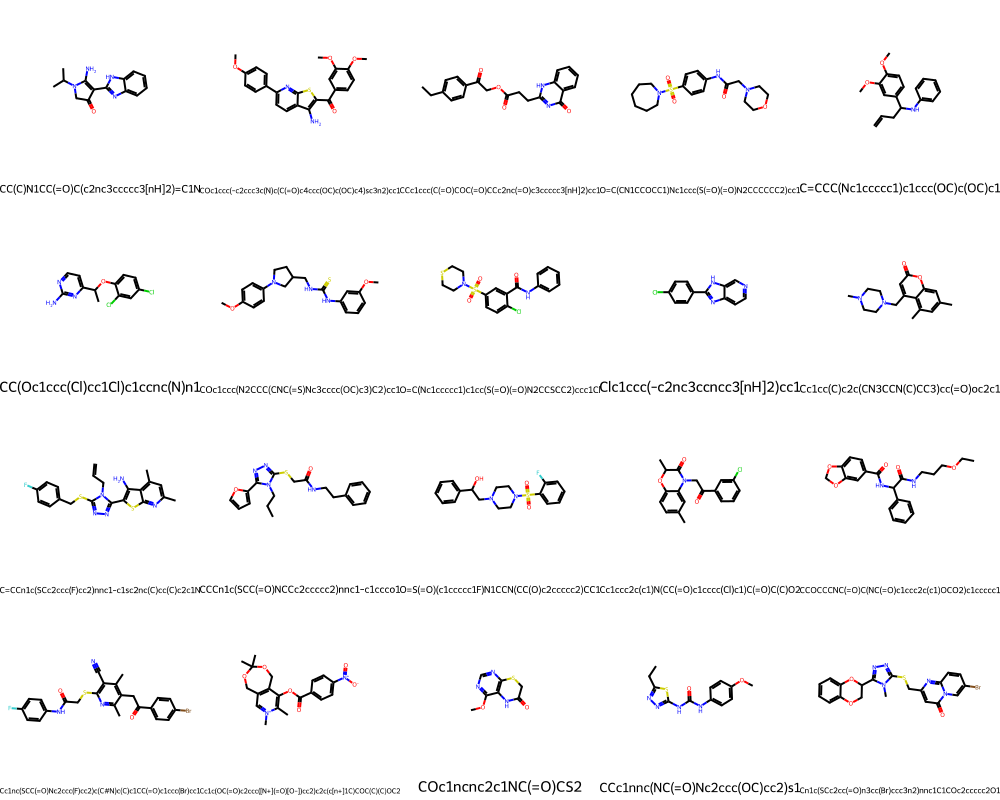

In [87]:
mols = df['mol'][:20]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['SMILES'][:20].values))

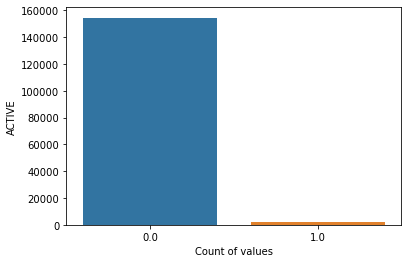

In [15]:
sns.countplot(data = df, x='ACTIVE', orient='v')
plt.ylabel('ACTIVE')
plt.xlabel('Count of values')
plt.show()

In [16]:
#Extract descriptors
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [17]:
y = df["ACTIVE"].values
X = df.drop(columns=["INDEX", "SMILES", "ACTIVE", "mol"])

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


In [18]:
def evaluation_class(model, X_test, y_test):
    prediction = model.predict_proba(X_test)
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score:', round(roc_auc, 4))

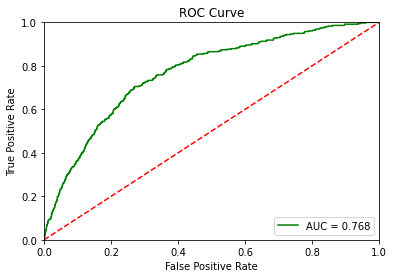

ROC AUC score: 0.7678


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

evaluation_class(lr, X_test, y_test)

In [25]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [27]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


KeyboardInterrupt: 

In [ ]:
best_clf.best_estimator_

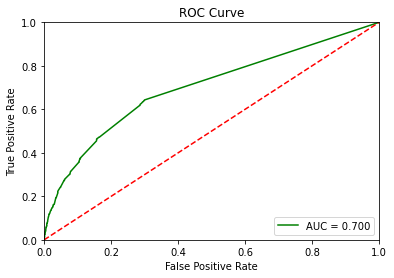

ROC AUC score: 0.6996


In [24]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
evaluation_class(rf, X_test, y_test)

In [132]:
y_pred1 = lr.predict(X_test)
print(sum(y_pred1 == y_test)/len(y_pred1))

0.9885447331370792


In [133]:
y_pred2 = rf.predict(X_test)
print(sum(y_pred2 == y_test)/len(y_pred2))

0.9879687699987201


In [70]:
from rdkit.Chem import AllChem

fp0 = AllChem.GetMorganFingerprintAsBitVect(df["mol"][0],1,nBits=124)
print(np.array(fp0))

[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0]


In [71]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(df["mol"][1],1,nBits=124)
print(np.array(fp1))

[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [72]:
fp_mat = np.zeros((df.index.size,124))
for i in range(df.index.size):
    fp_mat[i] = np.array(AllChem.GetMorganFingerprintAsBitVect(df['mol'][i],1,nBits=124))
print(fp_mat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [74]:
for j in range(fp_mat.shape[1]):
    df["fp{}".format(j)] = fp_mat[:,j]
print(df)

         INDEX                                             SMILES  ACTIVE  \
0            1               CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N     0.0   
1            2  COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...     0.0   
2            3    CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1     0.0   
3            4        O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1     0.0   
4            5                   C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1     0.0   
...        ...                                                ...     ...   
156253  156254  O=C(N/N=C\c1ccc(F)cc1)c1ccc(Cn2cc(Br)c([N+](=O...     0.0   
156254  156255  COc1ccc(NS(=O)(=O)c2cc(NC(=O)/C=C/c3cc(OC)ccc3...     0.0   
156255  156256            O=c1nc(N2CCN(Cc3ccccc3)CC2)[nH]c2c1CCC2     0.0   
156256  156257              Cc1onc(-c2ccccc2)c1C(=O)N/N=C/c1ccco1     0.0   
156257  156258                      CC(C)CCNC(=O)c1ccc2nc[nH]c2c1     0.0   

                                                      mol    tpsa       mol